In [1]:
# Standard libraries:
import os
import logging

# Third-party libraries:
import boto3
from catboost import CatBoostClassifier
import joblib
from joblib import dump
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [2]:
# Save location of notebook:
notebook_dir = os.getcwd()
notebook_dir

'/Users/jeongjaehui/Documents/Stats_404/JEONG-JAEHEE'

In [3]:
# Path to repository on my machine:
bankrupt_dir = "/Users/jeongjaehui/Documents/Stats_404/JEONG-JAEHEE"

In [4]:
# **Step 3**: Change directories to the repository on your local machine:

os.chdir(bankrupt_dir)

In [5]:
logging.basicConfig(level=logging.INFO)
# Define one logger for current file, per
# https://www.loggly.com/blog/4-reasons-a-python-logging-library-is-much-better-than-putting-print-statements-everywhere/
LOGGER = logging.getLogger(__name__)

In [6]:
BUCKET_NAME = "stats404-project-jaehee"
KEY_NAME_DATA = "bankrupt_data.csv"
KEY_NAME_MODEL = "cat_model.joblib"
FILE_NAME = "s3://stats404-project-jaehee/bankrupt_data.csv"

In [7]:
if __name__ == '__main__':
    ### ---------------------------------------------------------------------------
    ### --- Part 1: Connect to S3 Bucket on AWS
    ### ---------------------------------------------------------------------------
    LOGGER.info("--- Part 1: Connect to S3 Bucket on AWS")
    
    # Approach 1:
    s3 = boto3.resource('s3')

    # Approach 2:
    # - anon=False: use AWS credentials to connect to file system, not as an anonymous user
    s3_fs = s3fs.S3FileSystem(anon=False)
    LOGGER.info("List of buckets currently available on AWS S3:")
    for bucket in s3.buckets.all():
        if bucket.name == BUCKET_NAME:
            LOGGER.info(f"    {bucket.name}")
    LOGGER.info(f"List of objects in bucket {BUCKET_NAME}:")
    for file in s3.Bucket(BUCKET_NAME).objects.all():
        LOGGER.info(f"    {file.key}")

    ### ---------------------------------------------------------------------------
    ### --- Part 2: Download CSV File from S3 Bucket
    ### ---------------------------------------------------------------------------
    LOGGER.info("--- Part 2: Download CSV File from S3 Bucket")

    # --- Download  the dataset in my S3 Bucket and save as df:
    LOGGER.info("    Download a dataset for bankruptcy")
    df = pd.read_csv(filepath_or_buffer=FILE_NAME,
                     encoding='latin-1',
                     nrows=6819,
                     index_col=0
                    )

INFO:__main__:--- Part 1: Connect to S3 Bucket on AWS
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials
INFO:__main__:List of buckets currently available on AWS S3:
INFO:__main__:    stats404-project-jaehee
INFO:__main__:List of objects in bucket stats404-project-jaehee:
INFO:__main__:    bankrupt_data.csv
INFO:__main__:    cat_model.joblib
INFO:__main__:--- Part 2: Download CSV File from S3 Bucket
INFO:__main__:    Download a dataset for bankruptcy
INFO:botocore.credentials:Found credentials in shared credentials file: ~/.aws/credentials


In [8]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,operating gross margin,realized sales gross margin,operating profit rate,tax Pre-net interest rate,after-tax net interest rate,non-industry income and expenditure/revenue,...,net income to total assets,total assets to GNP price,No-credit interval,Gross profit to Sales,Net income to stockholder's Equity,liability to equity,Degree of financial leverage (DFL),Interest coverage ratio( Interest expense to EBIT ),one if net income was negative for the last two year zero otherwise,equity to liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [9]:
# ### Step 3-b: Read-in Data
# Read-in the data using the panda
#df = pd.read_csv('bankrupt_data.csv', encoding = 'latin-1')

In [10]:
#check row and columns
df.shape

(6819, 96)

In [11]:
#check if there are missing values
df.info()
#There is no missing value

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   Bankrupt?                                                            6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest             6819 non-null   float64
 2    ROA(A) before interest and % after tax                              6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax                   6819 non-null   float64
 4    operating gross margin                                              6819 non-null   float64
 5    realized sales gross margin                                         6819 non-null   float64
 6    operating profit rate                                               6819 non-null   float64
 7    tax P

In [12]:
#remove space from columns

COLUMNS = df.columns.tolist()
NO_SPACE_COLUMNS = [x.strip(' ') for x in COLUMNS]

df.columns = NO_SPACE_COLUMNS

In [13]:
#Since we have too many features, we will select some features that are meaningful using one of the feature selection methods, filter method.

#step1. Remove the features that have a low correlation with the target value.

#define funtions to get output features and an input feature.
def get_X(df):
    return(df.iloc[:,1:])

def get_y(df):
    return(df['Bankrupt?'])


net income to total assets                                -0.315457
ROA(A) before interest and % after tax                    -0.282941
ROA(B) before interest and depreciation after tax         -0.273051
ROA(C) before interest and depreciation before interest   -0.260807
net worth/assets                                          -0.250161
                                                             ...   
current liabilities to current assets                      0.171306
borrowing dependency                                       0.176543
current liability to assets                                0.194494
equity to liability                                       -0.083048
debt ratio %                                               0.250161
Length: 95, dtype: float64


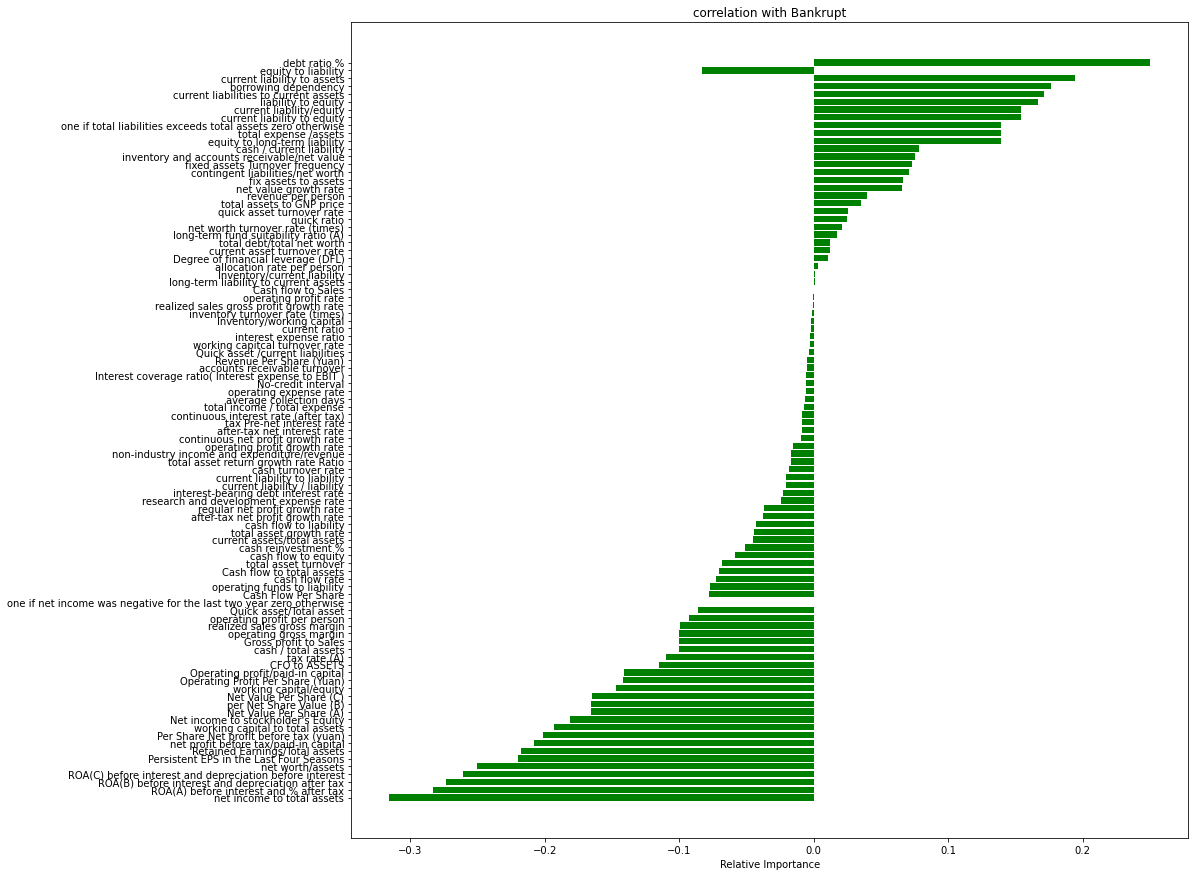

In [14]:
X = get_X(df)
y = get_y(df)

importances = X.apply(lambda x:x.corr(y))
indices = np.argsort(importances)
print(importances[indices])

COLUMNS = df.columns[1:]

plt.figure(figsize = (15, 15))

plt.title('correlation with Bankrupt')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [COLUMNS[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [15]:
#We will save the features that have a correlation higher than the absolute value of 0.10. Therefore, I will set the treshold to the absolute value of 0.10.
high_corr_columns = []

for i in range(0, len(indices)):
    if np.abs(importances[i])>0.10:     
        high_corr_columns.append(COLUMNS[i])
        print(COLUMNS[i])

print(len(high_corr_columns))

X = df.loc[:, high_corr_columns]

ROA(C) before interest and depreciation before interest
ROA(A) before interest and % after tax
ROA(B) before interest and depreciation after tax
operating gross margin
tax rate (A)
per Net Share Value (B)
Net Value Per Share (A)
Net Value Per Share (C)
Persistent EPS in the Last Four Seasons
Operating Profit Per Share (Yuan)
Per Share Net profit before tax (yuan)
debt ratio %
net worth/assets
borrowing dependency
Operating profit/paid-in capital
net profit before tax/paid-in capital
working capital to total assets
cash / total assets
current liability to assets
working capital/equity
current liability/equity
Retained Earnings/Total assets
total expense /assets
current liability to equity
equity to long-term liability
CFO to ASSETS
current liabilities to current assets
one if total liabilities exceeds total assets zero otherwise
net income to total assets
Gross profit to Sales
Net income to stockholder's Equity
liability to equity
32


In [16]:
#Step2: Remove the features that have a correlation higher than 90% with other independent variables.

corr = X.corr()

high_corr_columns_bool = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if high_corr_columns_bool[j]:
                high_corr_columns_bool[j] = False
                
selected_columns = X.columns[high_corr_columns_bool]

print(len(selected_columns))
#Now we only have 21 features. I will create a new df with these selected columns and the features that I think it's important.

new_df = pd.concat([df[['Bankrupt?', 'net income to total assets', 'Cash flow to total assets', 'tax Pre-net interest rate', 'inventory and accounts receivable/net value']],X[selected_columns]], axis=1)
print(new_df.columns)
print(new_df.shape)

#We have 25 features and target.

21
Index(['Bankrupt?', 'net income to total assets', 'Cash flow to total assets',
       'tax Pre-net interest rate',
       'inventory and accounts receivable/net value',
       'ROA(C) before interest and depreciation before interest',
       'operating gross margin', 'tax rate (A)', 'per Net Share Value (B)',
       'Persistent EPS in the Last Four Seasons',
       'Operating Profit Per Share (Yuan)', 'debt ratio %', 'net worth/assets',
       'borrowing dependency', 'working capital to total assets',
       'cash / total assets', 'current liability to assets',
       'working capital/equity', 'current liability/equity',
       'Retained Earnings/Total assets', 'total expense /assets',
       'equity to long-term liability', 'CFO to ASSETS',
       'current liabilities to current assets',
       'one if total liabilities exceeds total assets zero otherwise',
       'Net income to stockholder's Equity'],
      dtype='object')
(6819, 26)


In [17]:
#split the dataset into training and test sets

X = get_X(new_df)
y = get_y(new_df)

#use K-fold function to split data. 80% of the data will be training set and the rest of it will be test set.
skf = StratifiedKFold(n_splits = 5, shuffle = False)

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    Xtrain, Xtest = X.iloc[train_index], X.iloc[test_index]
    ytrain, ytest = y.iloc[train_index], y.iloc[test_index]

TRAIN: [1104 1118 1132 ... 6816 6817 6818] TEST: [   0    1    2 ... 1383 1384 1385]
TRAIN: [   0    1    2 ... 6816 6817 6818] TEST: [1104 1118 1132 ... 2796 2797 2798]
TRAIN: [   0    1    2 ... 6816 6817 6818] TEST: [1860 1861 1862 ... 4136 4137 4138]
TRAIN: [   0    1    2 ... 6816 6817 6818] TEST: [2100 2147 2148 ... 5475 5476 5477]
TRAIN: [   0    1    2 ... 5475 5476 5477] TEST: [3749 3908 4071 ... 6816 6817 6818]


In [18]:
#export a training set and a test set as csv
Xtrain.to_csv(r'C:\Users\jeongjaehui\Documents\Stats_404\JEONG-JAEHEE\bankrupt_training_set.csv', index = False, header=True)
Xtest.to_csv(r'C:\Users\jeongjaehui\Documents\Stats_404\JEONG-JAEHEE\bankrupt_test_set.csv', index = False, header=True)

In [19]:
Xtrain.shape

(5456, 25)

In [20]:
Xtest.shape

(1363, 25)

In [21]:
#splite the data into training and valiation sets

X_train, X_val, y_train, y_val = train_test_split(Xtrain, ytrain, test_size = 0.1, random_state = 1,stratify = ytrain, shuffle = True)

In [22]:
#generate a logistics regression model

log_reg = LogisticRegression(class_weight='balanced', max_iter=10000)
log_model = log_reg.fit(X_train, y_train)
log_pred = log_model.predict(X_val)

#check a classification

print(classification_report(y_val, log_pred))

#defie a function to print confusion matrix
def print_confusion_matrix(y_val, pred):
    print(pd.DataFrame(confusion_matrix(y_val, pred), columns = ['Predicted Nagative', 'Predicted Positive'], index = ['Actual Negative', 'Actual Positive']))
    
print_confusion_matrix(y_val, log_pred)

              precision    recall  f1-score   support

           0       1.00      0.83      0.91       528
           1       0.16      0.94      0.27        18

    accuracy                           0.84       546
   macro avg       0.58      0.89      0.59       546
weighted avg       0.97      0.84      0.89       546

                 Predicted Nagative  Predicted Positive
Actual Negative                 439                  89
Actual Positive                   1                  17


In [23]:
log_pred = log_model.predict(Xtest)

#check a classification & confusion matrix
print(classification_report(ytest, log_pred))
print_confusion_matrix(ytest, log_pred)

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      1319
           1       0.26      0.89      0.41        44

    accuracy                           0.92      1363
   macro avg       0.63      0.90      0.68      1363
weighted avg       0.97      0.92      0.94      1363

                 Predicted Nagative  Predicted Positive
Actual Negative                1210                 109
Actual Positive                   5                  39


In [24]:
#create a model using catboost
cat = CatBoostClassifier(iterations=500,
                           loss_function='Logloss',
                           depth=6,
                           l2_leaf_reg=1e-20,
                           eval_metric='Accuracy',
                           leaf_estimation_iterations=10,
                           use_best_model=True,
                           logging_level='Silent',
                           random_seed=42,
                           class_weights = (1, 30)
                          )
                          
cat_model = cat.fit(X_train,y_train, eval_set = (X_val,y_val))
cat_pred = cat_model.predict(X_val)

In [25]:
print(classification_report(y_val, cat_pred))
print_confusion_matrix(y_val, cat_pred)

              precision    recall  f1-score   support

           0       1.00      0.87      0.93       528
           1       0.19      0.89      0.31        18

    accuracy                           0.87       546
   macro avg       0.59      0.88      0.62       546
weighted avg       0.97      0.87      0.91       546

                 Predicted Nagative  Predicted Positive
Actual Negative                 460                  68
Actual Positive                   2                  16


In [26]:
cat_pred = cat_model.predict(Xtest)

print(classification_report(ytest, cat_pred))
print_confusion_matrix(ytest, cat_pred)

              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1319
           1       0.26      0.84      0.39        44

    accuracy                           0.92      1363
   macro avg       0.62      0.88      0.67      1363
weighted avg       0.97      0.92      0.94      1363

                 Predicted Nagative  Predicted Positive
Actual Negative                1211                 108
Actual Positive                   7                  37


(0.0, 1.0)

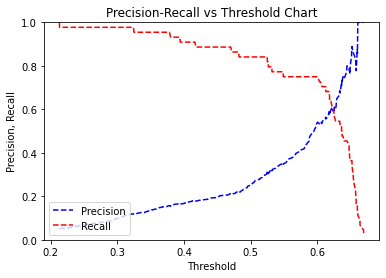

In [27]:
#generate a precision recall curve to check if we can change the threshold to increase FalseNegative.

probs = cat_model.predict_proba(Xtest)
positive_probs = probs[:, 1]


precision, recall, thresholds = precision_recall_curve(ytest, positive_probs) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])


In [28]:
def cat_model_pred_prob_threshold_37(X_data):
    return(np.where(cat_model.predict_proba(X_data)[:,1] > 0.37, 1, 0))

thre_37_preds_cat = cat_model_pred_prob_threshold_37(X_val)

In [29]:
#check a classification
print(classification_report(y_val, thre_37_preds_cat))
print_confusion_matrix(y_val, thre_37_preds_cat)

              precision    recall  f1-score   support

           0       1.00      0.71      0.83       528
           1       0.10      0.94      0.18        18

    accuracy                           0.72       546
   macro avg       0.55      0.83      0.50       546
weighted avg       0.97      0.72      0.81       546

                 Predicted Nagative  Predicted Positive
Actual Negative                 374                 154
Actual Positive                   1                  17


In [30]:
thre_37_preds_cat = cat_model_pred_prob_threshold_37(Xtest)

#check a classification
print(classification_report(ytest, thre_37_preds_cat))
print_confusion_matrix(ytest, thre_37_preds_cat)

              precision    recall  f1-score   support

           0       1.00      0.82      0.90      1319
           1       0.15      0.95      0.26        44

    accuracy                           0.83      1363
   macro avg       0.58      0.89      0.58      1363
weighted avg       0.97      0.83      0.88      1363

                 Predicted Nagative  Predicted Positive
Actual Negative                1085                 234
Actual Positive                   2                  42


In [31]:
a = df[df['Bankrupt?']==1]
a = a.mean()

In [32]:
a['Operating Profit Per Share (Yuan)']

0.08735370972159508

In [33]:
# Specify location and name of object to contain estimated model:
model_object_path = os.path.join(notebook_dir, 'cat_model.joblib')

In [34]:
# Save estimated model to specified location:
dump(cat_model, model_object_path)

['/Users/jeongjaehui/Documents/Stats_404/JEONG-JAEHEE/cat_model.joblib']

In [35]:
if __name__ == '__main__':
    
    ### ---------------------------------------------------------------------------
    ### --- Part 3: Upload Model Object to S3 Bucket
    ### ---------------------------------------------------------------------------
    LOGGER.info("--- Part 3: Upload Model Object to S3 Bucket")
    LOGGER.info("    Loading Catboost model object")
    cat_model = joblib.load("cat_model.joblib")

    # --- Specify name of file to be created on s3, to store this model object:
    LOGGER.info(f"    Uploading file: {KEY_NAME_MODEL} to S3 bucket = {BUCKET_NAME}")
    with s3_fs.open(f"{BUCKET_NAME}/{KEY_NAME_MODEL}", "wb") as file:
        joblib.dump(cat_model, file)
    LOGGER.info(f"    Uploaded file: {KEY_NAME_MODEL} to S3 bucket = {BUCKET_NAME}")
    LOGGER.info(f"List of objects in bucket {BUCKET_NAME} now:")
    for file in s3.Bucket(BUCKET_NAME).objects.all():
        LOGGER.info(f"    {file.key}")

INFO:__main__:--- Part 3: Upload Model Object to S3 Bucket
INFO:__main__:    Loading Catboost model object
INFO:__main__:    Uploading file: cat_model.joblib to S3 bucket = stats404-project-jaehee
INFO:__main__:    Uploaded file: cat_model.joblib to S3 bucket = stats404-project-jaehee
INFO:__main__:List of objects in bucket stats404-project-jaehee now:
INFO:__main__:    bankrupt_data.csv
INFO:__main__:    cat_model.joblib
